## Key Idea
Using a kernel to rebalance the weights of data points close to the threshold

When the treatment is a discontinuous function and potential outcomes before and after a threshold like
minimal drinking age (21) and the impact of alcochol compsuption on mortality. 
The idea is to run a regression model with a binary variable.

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
plt.rcParams["figure.figsize"] = (5,4)
style.use("fivethirtyeight")

In [2]:
drinking = pd.read_csv("./data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


In [3]:
drinking['agecell'] -= 21

In [5]:
df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))
model = smf.wls("all~agecell*threshold", df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


The model tells us with a P-value less than 0.001 that mortality increases by 7.6627 with consumption of alcohol.
So we should not lower the minimal age of drinking.

We want to verify this model visually

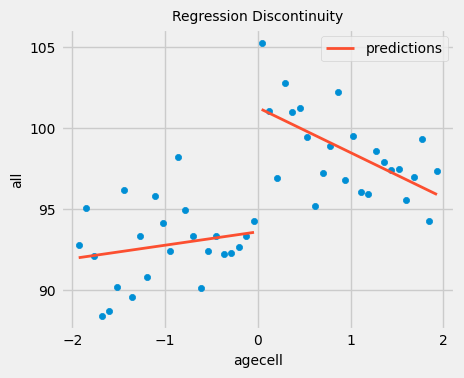

In [22]:
ax = plt.subplot(111)
drinking.plot.scatter(x="agecell", y="all", color="C0",fontsize=10, ax=ax)
plt.xlabel("agecell", fontsize=10)
plt.ylabel("all", fontsize=10)
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1", lw=2, fontsize=10)
plt.title("Regression Discontinuity", fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

The model could give focus too much on fitting the data points away from the threshold.
One way to solve this is to give higher weights for the points closer to the threshold.
One way to do this is to use the triangular kernel

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

In [25]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(int)
    return indicator * (1 - np.abs(R - c) / h)

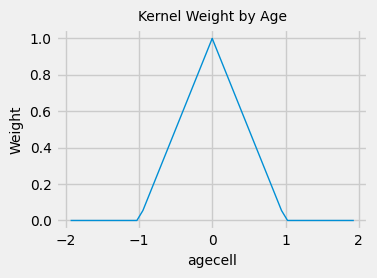

In [34]:
plt.figure(figsize=(4,3))
ax = plt.subplot(111)
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1), lw=1)
plt.xlabel("agecell", fontsize=10)
plt.ylabel("Weight", fontsize=10)
plt.title("Kernel Weight by Age", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()
plt.close()

In [36]:
model = smf.wls("all~agecell*threshold", df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


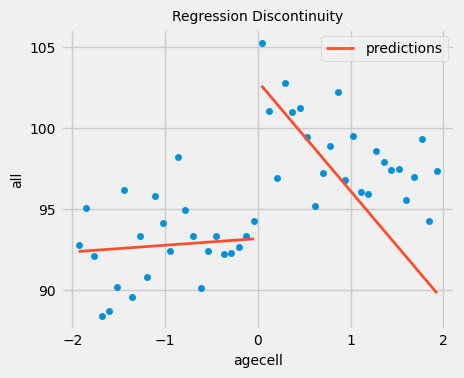

In [39]:
plt.figure(figsize=(5,4))
ax = plt.subplot(111)
drinking.plot.scatter(x="agecell", y="all", color="C0",fontsize=10, ax=ax)
plt.xlabel("agecell", fontsize=10)
plt.ylabel("all", fontsize=10)
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1", lw=2, fontsize=10)
plt.title("Regression Discontinuity", fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

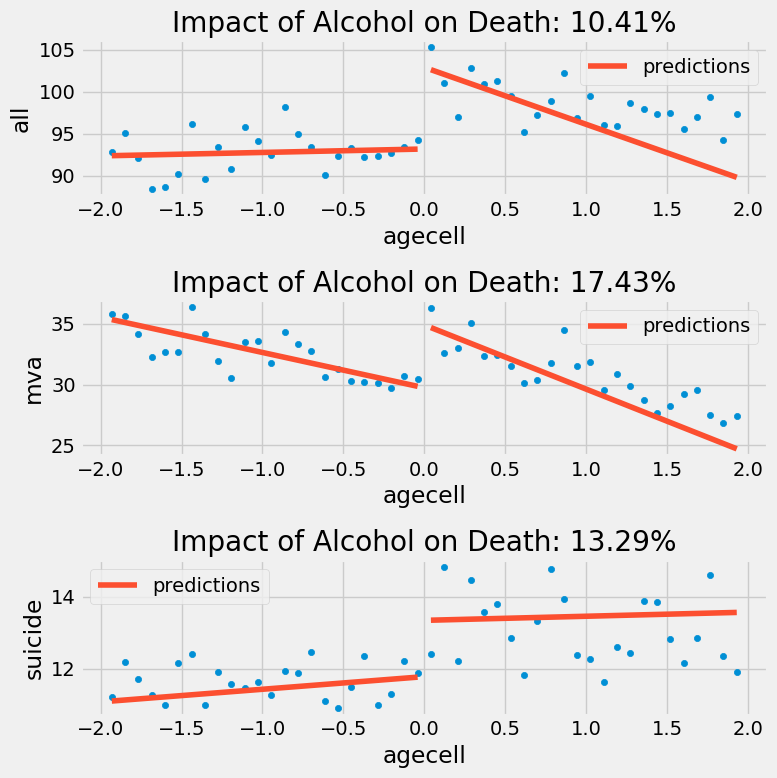

In [45]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", df, weights=weights).fit()
    ate_pct = 100*(m.params["threshold"]/m.params["Intercept"])
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

With the exception of suicide, it looks like adding the kernel weight made the negative impact on alcohol bigger. Once again, if we want to minimize the death rate, we should NOT recommend lowering the legal drinking age, since there is a clear impact of alcohol on the death rates.

